## **GIS 강의 3주차**

---

### **1. 대구, 경북, 낙동강 shp 파일 불러오기**
* 1-1) 데이터 import 

### **2. 공간 데이터 핸들링**
* 2-1) 데이터 확인
* 2-2) 대구, 경북 하천용도 구역 데이터 결합하기 
* 2-3) 공간 데이터 핸들링 
* 2-4) 낙동강 지역 필터링

----


In [1]:
import os 
import sys 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd 
import folium
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from pandas_profiling import ProfileReport
import warnings

In [5]:
# Jupyter 환경 설정 

warnings.filterwarnings(action='ignore') 
plt.rcParams['font.family']='AppleGothic'
file_path='/Users/dk/Documents'



In [6]:
os.getcwd()

'/Users/dk/Documents'

---

### 1. 대구,경북,낙동강 shp 파일 불러오기 

#### 1-1) Data import 

In [91]:
# 시도 
korea_sido_shp=gpd.read_file(
	filename='./data/korea_sido_shp/ctp_rvn.shp',
	encoding='EUC-KR'
)

# 시군구 
korea_sig_shp=gpd.read_file(
	filename='./data/korea_sig_shp/sig.shp',
	encoding='EUC-KR'
)

# 행정동 
korea_adm_shp=gpd.read_file(
	filename='./data/korea_adm_shp/emd.shp',
	encoding='EUC-KR'
)

# 경북, 대구 낙동강 수계 shp (Bessel 보정된 중부원점 (TM)) 

gyeongbuk_river_shp=gpd.read_file(
	filename='./data/gyeongbuk_river_shp/LSMD_CONT_UJ201_47_202209.shp',
	encoding='EUC-KR'
)

daegu_river_shp=gpd.read_file(
	filename='./data/daegu_river_shp/LSMD_CONT_UJ201_27_202209.shp',
	encoding='EUC-KR'
)



---

### 2. 공간데이터 핸들링 

#### 2-1) 데이터 핸들링
#### 2-2) 대구, 경북 하천용도 구역 데이터 결합하기 
#### 2-3) 공간 데이터 핸들링 
#### 2-4) 낙동강 지역 필터링

---

#### 2-1) 데이터 핸들링

In [92]:
# 컬럼명 소문자로 변경 

korea_sido_shp.columns=map(str.lower, korea_sido_shp.columns)
korea_sig_shp.columns=map(str.lower, korea_sig_shp.columns)
korea_adm_shp.columns=map(str.lower, korea_adm_shp.columns)
gyeongbuk_river_shp.columns=map(str.lower, gyeongbuk_river_shp.columns)
daegu_river_shp.columns=map(str.lower, daegu_river_shp.columns)


* 안쓰는 컬럼 drop, 컬럼명 rename


In [86]:
# 경북지역 확인 
gyeongbuk_river_shp.head()

,mnum,alias,remark,ntfdate,sgg_oid,col_adm_se,geometry
0,64700004711020220032UJB1000001002,지방하천(곡강천),None,None,1340,47110,"POLYGON ((404364.980 298591.245, 404374.554 29..."
1,64700004711020110083UJB1000001001,병보천(지방하천),None,None,33,47110,"POLYGON ((384977.599 309716.307, 384977.775 30..."
2,15000004711020090370UJB1000001001,국가하천 형산강,None,None,34,47110,"POLYGON ((407012.212 279653.943, 407020.450 27..."
3,64700004711020210376UJB1000100001,하천구역,자호천,20211115,1335,47110,"POLYGON ((391893.153 304067.818, 391917.156 30..."
4,64700004711020140418UJB1000001002,청하천,None,20141201,50,47110,"POLYGON ((407183.618 304680.973, 407195.229 30..."


In [87]:
# 대구지역 확인 
daegu_river_shp.head()

,mnum,alias,remark,ntfdate,sgg_oid,col_adm_se,geometry
0,62700002714020090203UJB1000001001,율하천,하천부근토지에 대해서는 건설과 문의바람,None,38,27140,"POLYGON ((351720.976 264490.404, 351744.445 26..."
1,62700002714020100169UJB1000003000,지묘천,홍수피해예방(하천기본계획 재수립),None,39,27140,"POLYGON ((346790.934 275636.553, 346792.601 27..."
2,62700002714020100169UJB1000002000,용수천,홍수피해예방(하천기본계획 재수립),None,40,27140,"POLYGON ((349954.140 278370.776, 349966.041 27..."
3,62700002714020100169UJB4000001000,용수천,홍수피해예방 (하천기본계획 재수립),None,41,27140,"MULTIPOLYGON (((351070.968 276024.002, 351071...."
4,16132812714020200618UJB1000001001,금호강,국가하천,20201218,1649,27140,"POLYGON ((346790.580 268322.537, 346793.156 26..."


In [93]:
# 미사용 컬럼 drop 

gyeongbuk_river_shp.drop(
	columns=[
		'mnum',
		'remark',
		'ntfdate',
		'sgg_oid',
	],
	inplace=True
)


daegu_river_shp.drop(
	columns=[
		'mnum',
		'remark',
		'ntfdate',
		'sgg_oid',
	],
	inplace=True
)





In [96]:
# {시도 : sido, 시군구 :sig, 행정동 : adm}

korea_sido_shp.rename(
	columns={
		'ctprvn_cd': 'sido_cd',
		'ctp_eng_nm': 'sido_eng_nm',
		'ctp_kor_nm': 'sido_kor_nm'
	},
	inplace=True
)

#행정동 

korea_adm_shp.rename(
	columns={
		'emd_cd': 'adm_cd',
		'emd_eng_nm': 'adm_eng_nm',
		'emd_kor_nm': 'adm_kor_nm'
	},
	inplace=True
)

# 경북 강

gyeongbuk_river_shp.rename(
	columns={
		'alias': 'river_nm',
		'col_adm_se': 'sig_cd'
	},
	inplace=True
)

# 대구 강 

daegu_river_shp.rename(
	columns={
		'alias': 'river_nm',
		'col_adm_se': 'sig_cd'
	},
	inplace=True
)



#### 2-2) 대구, 경북 하천용도 구역 데이터 결합하기 


In [99]:

river_shp=pd.concat(
	[
		gyeongbuk_river_shp,
		daegu_river_shp
	],
	ignore_index=True
)

river_shp.head()

,river_nm,sig_cd,geometry
0,지방하천(곡강천),47110,"POLYGON ((404364.980 298591.245, 404374.554 29..."
1,병보천(지방하천),47110,"POLYGON ((384977.599 309716.307, 384977.775 30..."
2,국가하천 형산강,47110,"POLYGON ((407012.212 279653.943, 407020.450 27..."
3,하천구역,47110,"POLYGON ((391893.153 304067.818, 391917.156 30..."
4,청하천,47110,"POLYGON ((407183.618 304680.973, 407195.229 30..."


* epsg 좌표계 변환 (5179로 전부 통일)

In [107]:
korea_sido_shp=korea_sido_shp.to_crs({'init': 'epsg:5179'})
korea_sig_shp=korea_sig_shp.to_crs({'init': 'epsg:5179'})
korea_adm_shp=korea_adm_shp.to_crs({'init': 'epsg:5179'})
river_shp=river_shp.to_crs({'init': 'epsg:5179'})

* 대구 경북 지역만 추출 (대구 :27 , 경북 : 47)


In [108]:
sido_cond=korea_sido_shp['sido_cd'].isin(['27','47'])
sig_cond=korea_sig_shp['sig_cd'].str[0:2].isin(['27','47'])
adm_cond=korea_adm_shp['adm_cd'].str[0:2].isin(['27','47'])

dgb_sido_shp=korea_sido_shp[sido_cond]
dgb_sig_shp=korea_sig_shp[sig_cond]
dgb_adm_shp=korea_adm_shp[adm_cond]


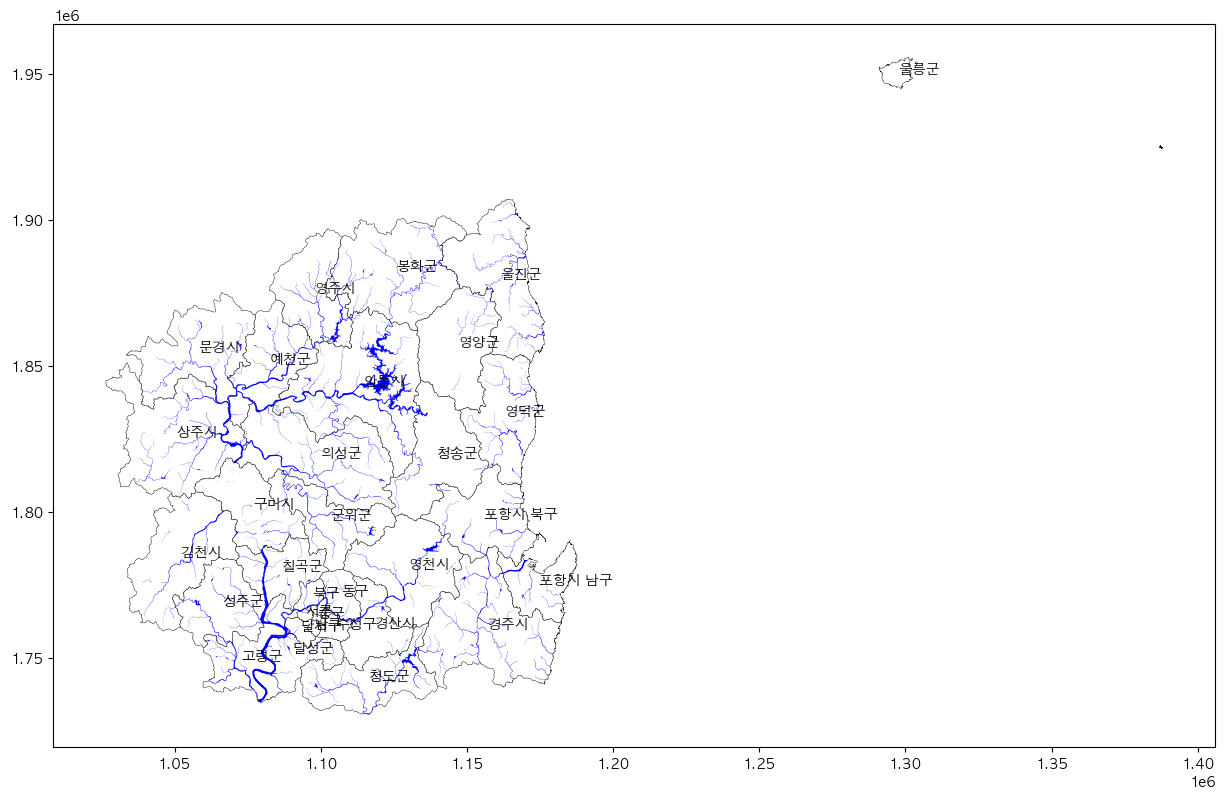

In [137]:
fig, ax=plt.subplots(1,1,figsize=(15,15)) 


spot_x = dgb_sig_shp.centroid.x
spot_y = dgb_sig_shp.centroid.y

dgb_sig_shp.plot(ax=ax,color='white',edgecolor='black',linewidth=0.3)
river_shp.buffer(10).plot(ax=ax,color='blue')


for x,y,nm in zip(spot_x,spot_y,dgb_sig_shp.sig_kor_nm):
	plt.text(
		x,
		y,
		nm
	)
	
plt.show()

* 구미 지역의 낙동강이 끊어져 있어 shape 파일 보수가 필요
* n by n cell 을 만들어 해당 셀이 강을 포함하는지, 공장이 몇개인지, 인근 지역에 비해 갑작스럽게 수질오염도가 높아졌는지등을 확인할 예정 


[하천용도 구역 shp 파일 다운로드](http://data.nsdi.go.kr/dataset/12843)